In [1]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from livelossplot import PlotLossesKerasTF
import tensorflow as tf

In [2]:
print("\nTraining dataset\n")
for expression in os.listdir("/Users/chetananannapaneni/Downloads/images/images/train/"):
    print(str(len(os.listdir("/Users/chetananannapaneni/Downloads/images/images/train/" + expression))) + " " + expression + " images")
print("\nTest dataset\n")
for expression in os.listdir("/Users/chetananannapaneni/Downloads/images/images/validation/"):
    print(str(len(os.listdir("/Users/chetananannapaneni/Downloads/images/images/validation/" + expression))) + " " + expression + " images")


Training dataset

7164 happy images
4939 sad images
4104 fear images
3205 surprise images
4982 neutral images
3993 angry images
436 disgust images

Test dataset

1825 happy images
1139 sad images
1018 fear images
797 surprise images
1216 neutral images
960 angry images
111 disgust images


In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/Users/chetananannapaneni/Downloads/images/images/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/Users/chetananannapaneni/Downloads/images/images/validation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28823 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


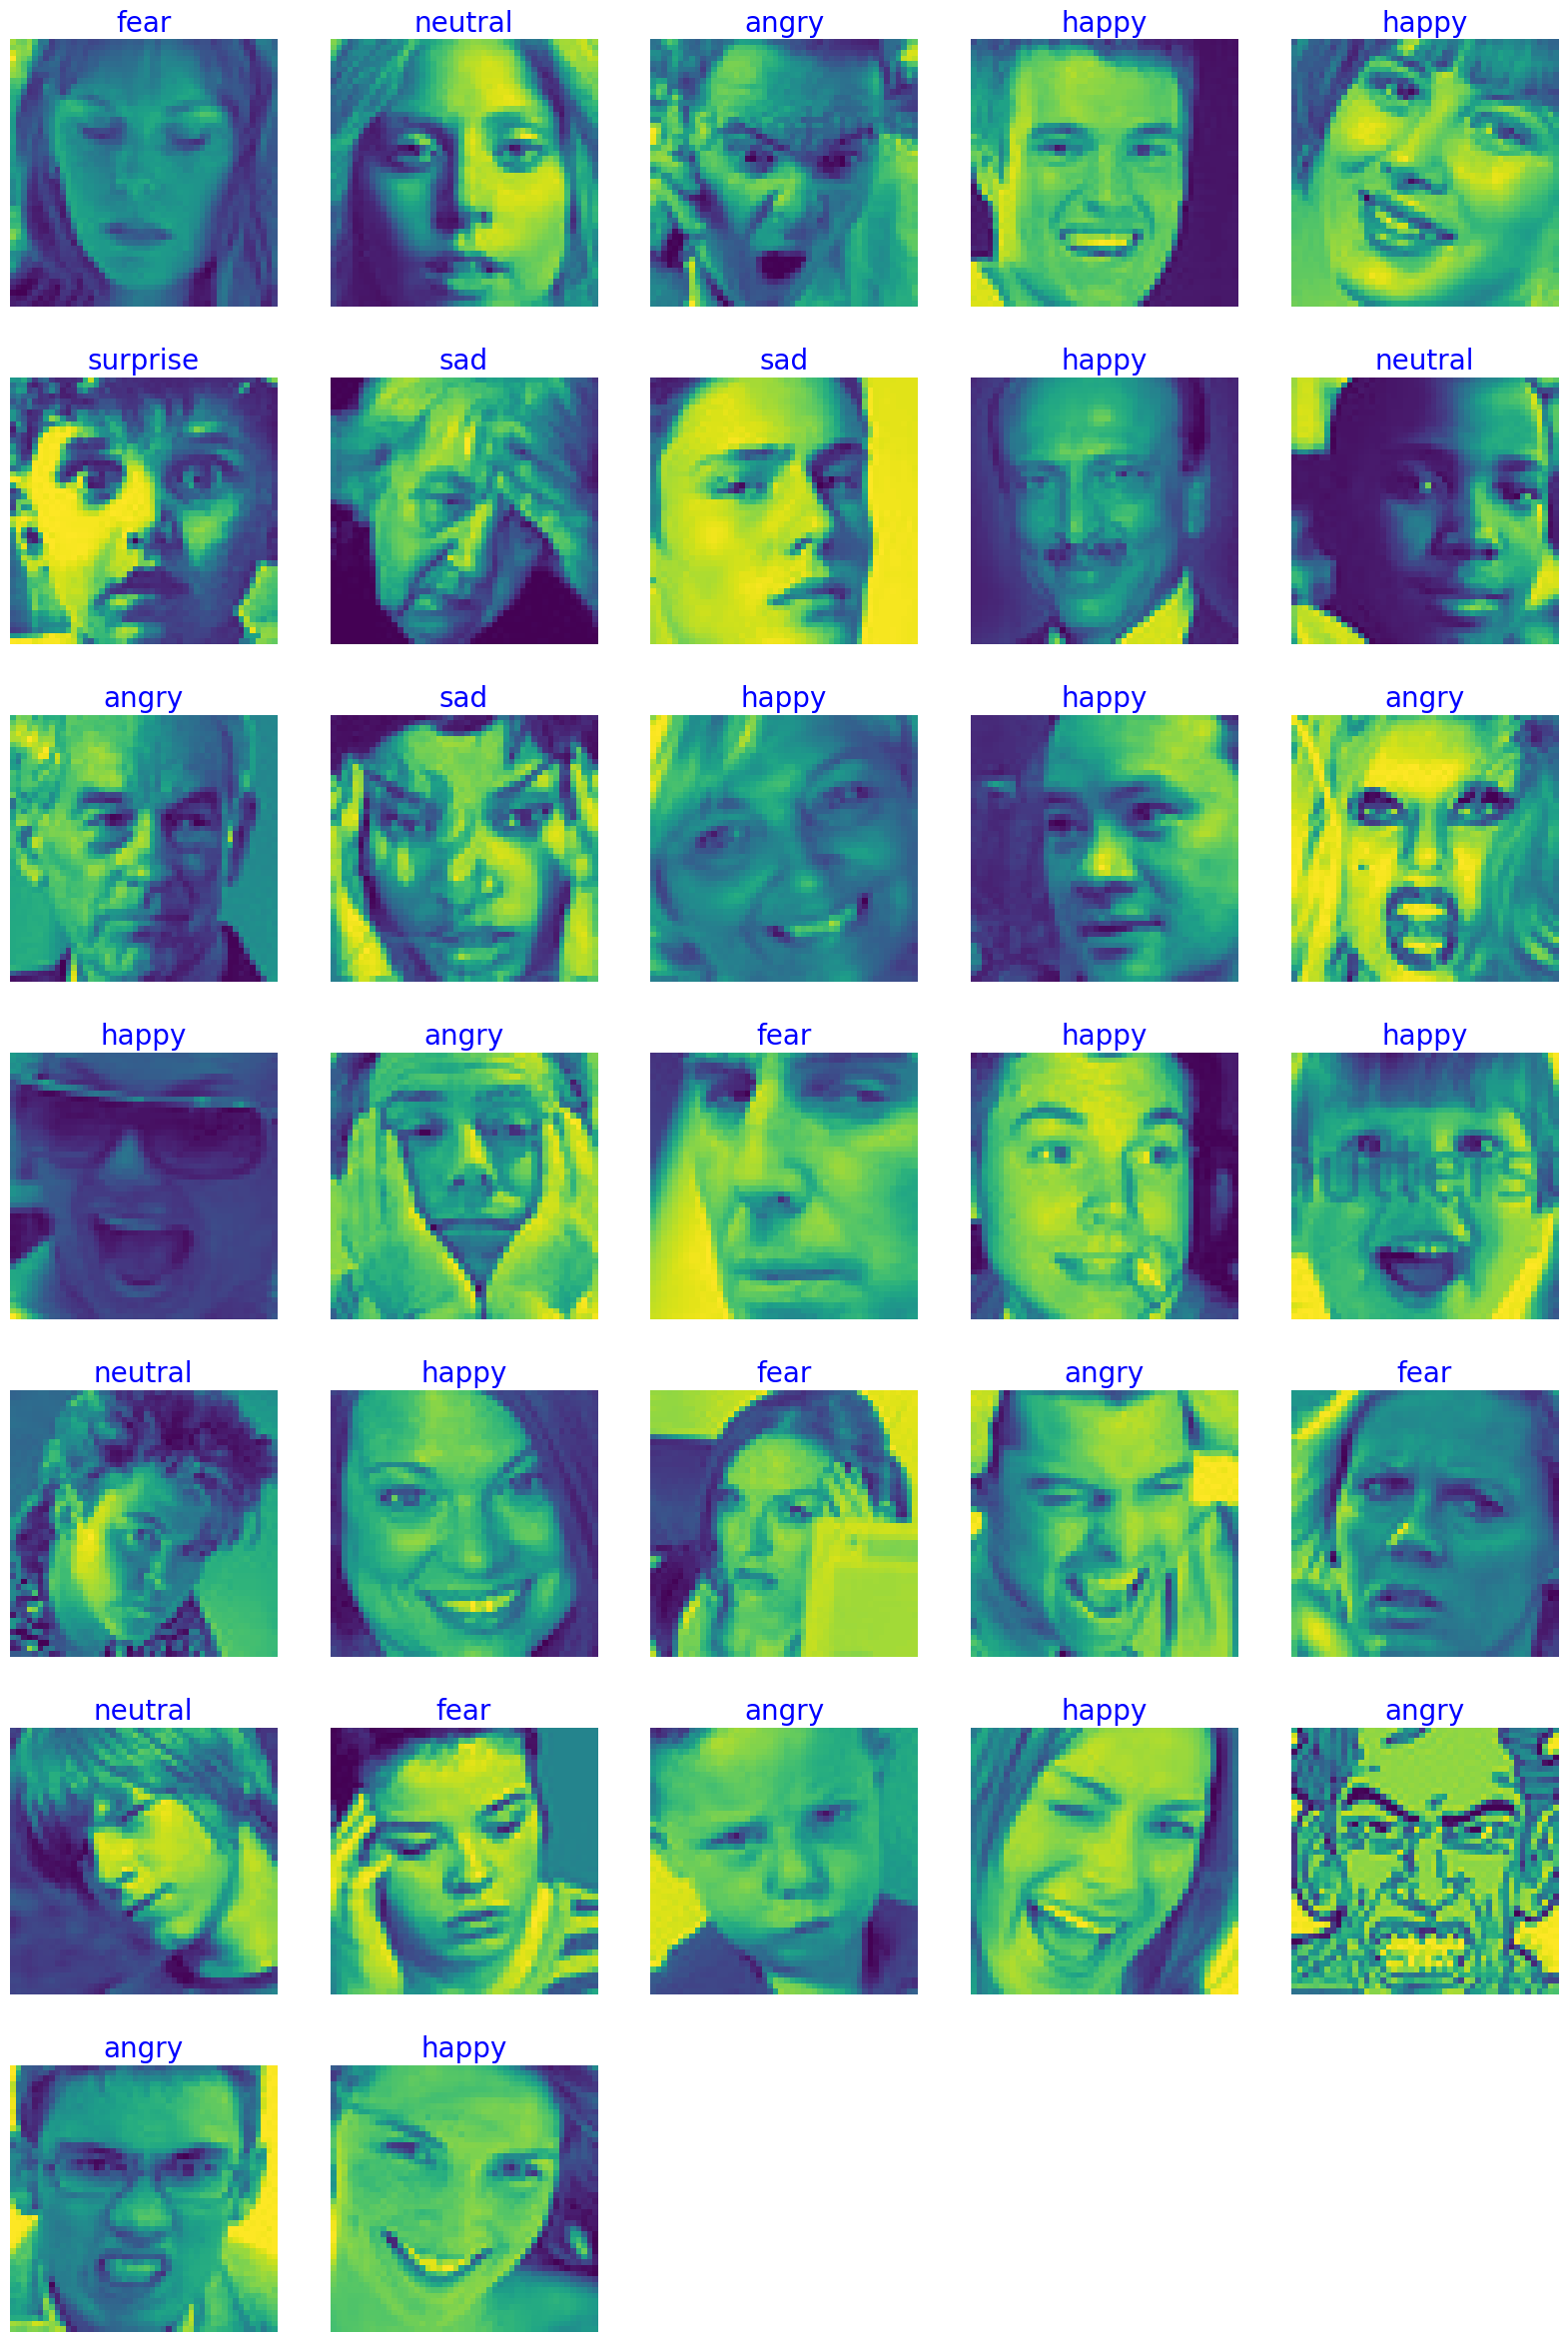

In [4]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:  
        r=length
    else:
        r=32
    for i in range(r):        
        plt.subplot(7, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ", 
                    color='blue', 
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)


In [5]:
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

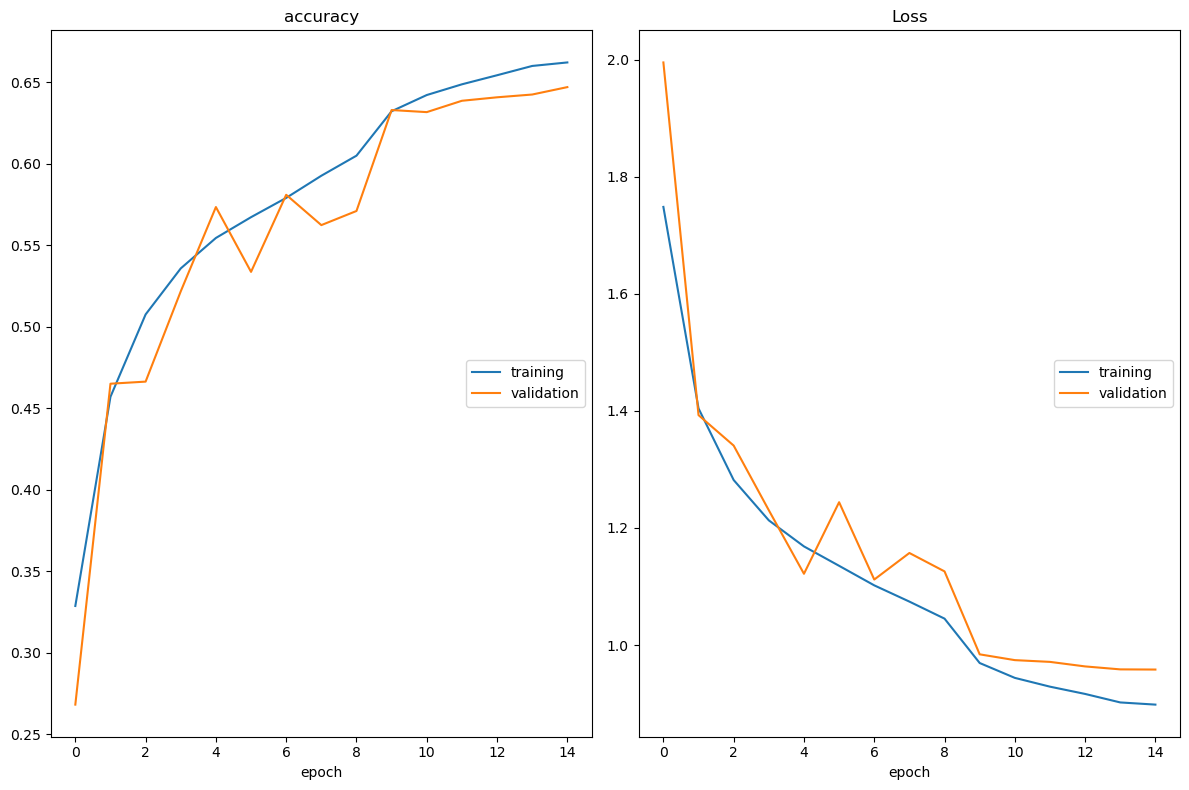

accuracy
	training         	 (min:    0.329, max:    0.662, cur:    0.662)
	validation       	 (min:    0.268, max:    0.647, cur:    0.647)
Loss
	training         	 (min:    0.898, max:    1.748, cur:    0.898)
	validation       	 (min:    0.958, max:    1.995, cur:    0.958)

Epoch 15: saving model to model_weights.h5
450/450 [==============================] - 566s 1s/step - loss: 0.8982 - accuracy: 0.6623 - val_loss: 0.9581 - val_accuracy: 0.6472 - lr: 1.0000e-04
CPU times: user 3h 43min 5s, sys: 13min 49s, total: 3h 56min 55s
Wall time: 1h 47min 57s


In [6]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
#Confution Matrix
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
# plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/var/folders/0g/mcyw6dvx4zl6m924cj27nym00000gn/T/ipykernel_37425/1230679374.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.60      0.50      0.54       960
     disgust       0.65      0.59      0.62       111
        fear       0.52      0.39      0.45      1018
       happy       0.81      0.88      0.85      1825
     neutral       0.57      0.63      0.60      1216
         sad       0.50      0.53      0.52      1139
    surprise       0.72      0.80      0.76       797

    accuracy                           0.65      7066
   macro avg       0.63      0.62      0.62      7066
weighted avg       0.64      0.65      0.64      7066



/var/folders/0g/mcyw6dvx4zl6m924cj27nym00000gn/T/ipykernel_37425/2120926517.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.59      0.49      0.54       960
     disgust       0.68      0.59      0.63       111
        fear       0.53      0.40      0.46      1018
       happy       0.81      0.88      0.84      1825
     neutral       0.57      0.62      0.60      1216
         sad       0.50      0.53      0.52      1139
    surprise       0.73      0.80      0.76       797

    accuracy                           0.64      7066
   macro avg       0.63      0.62      0.62      7066
weighted avg       0.64      0.64      0.64      7066



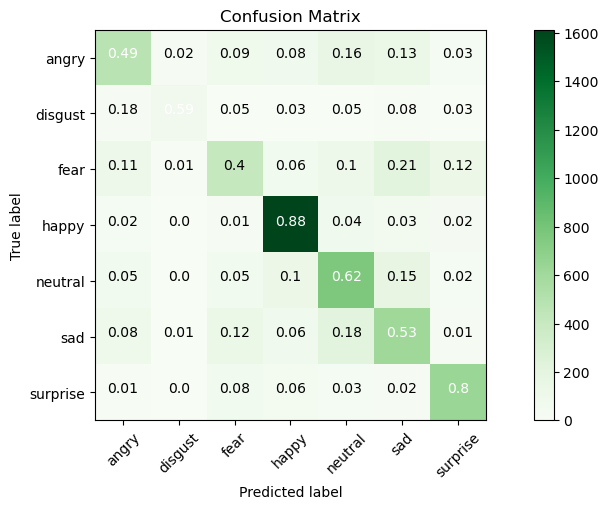

In [9]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

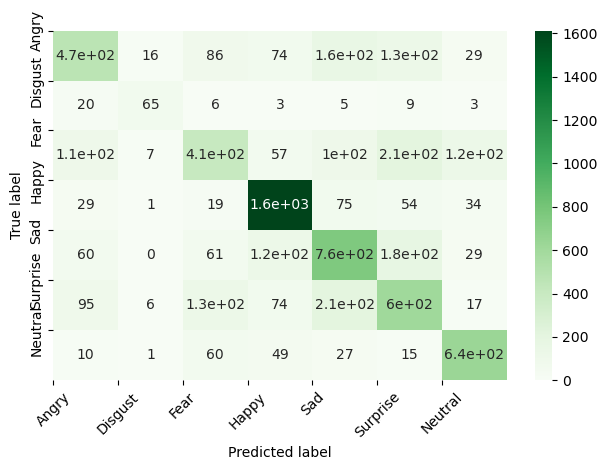

In [10]:
# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#plt.imshow(cm, interpolation='nearest',cmap='Greens',annot='true')
sns.heatmap(cm,cmap='Greens',annot=True)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [11]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [27]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0
    

In [37]:
image = '/Users/chetananannapaneni/Downloads/images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 [==============================] - 0s 46ms/step
model prediction is  sad


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 [==============================] - 0s 55ms/step
model prediction is  sad


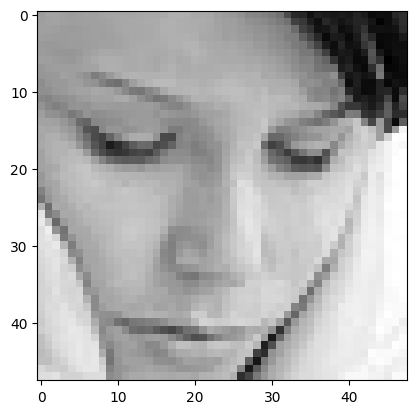

In [42]:
image = '/Users/chetananannapaneni/Downloads/images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 [==============================] - 0s 17ms/step
model prediction is  sad


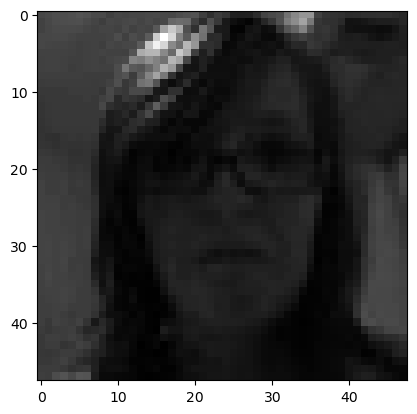

In [43]:
image = '/Users/chetananannapaneni/Downloads/images/train/fear/407.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 [==============================] - 0s 57ms/step
model prediction is  disgust


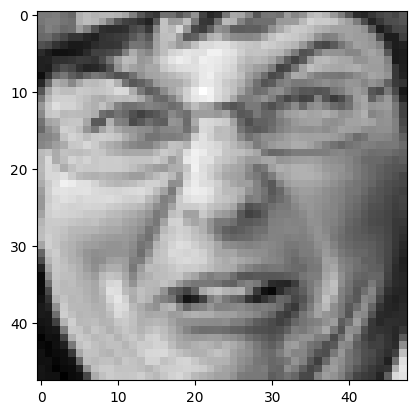

In [44]:
image = '/Users/chetananannapaneni/Downloads/images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 42ms/step
model prediction is  happy


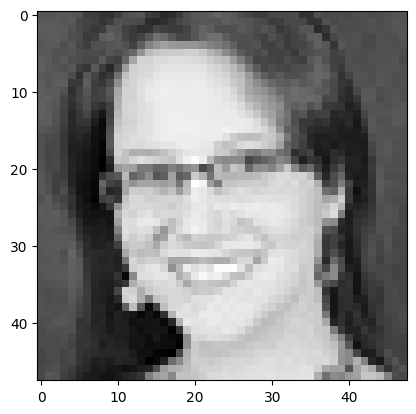

In [45]:
image = '/Users/chetananannapaneni/Downloads/images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 40ms/step
model prediction is  surprise


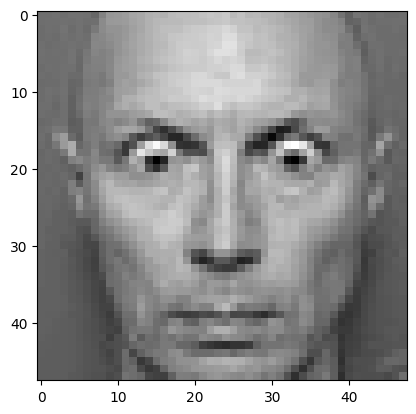

In [46]:
image = '/Users/chetananannapaneni/Downloads/images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')